In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

quant = pd.read_csv("ravdess_quantitative.csv")
categ = pd.read_csv("ravdess_categorical.csv")
categ.drop(columns=["actor"], inplace=True)

from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import silhouette_score, mutual_info_score, adjusted_mutual_info_score
from sklearn.pipeline import make_pipeline

In [230]:
from sklearn.metrics import adjusted_mutual_info_score as ami, silhouette_score

def meanAMI(labels, dataframe):
    mAMI= 0 
    
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        mAMI += featAMI/len(dataframe.columns)
    return mAMI

def get_maxAMI_feature(labels, dataframe):
    MAMI = 0
    MAMIfeat = dataframe.columns[0]
    for feat in dataframe.columns:
        featAMI = ami(labels, dataframe[feat])
        MAMIfeat = feat if featAMI > MAMI else MAMIfeat
        MAMI = max(MAMI, featAMI)
    return MAMIfeat, MAMI


In [231]:
def greedy_optimizer(classifier, method="AMI"):
    """chooses the features tat maximise the classifier performance"""
    features = list(quant.columns)
    combos = [[col] for col in features]
    best_features = []
    for i in range(2):
        scores = []
        categories = []
        amis = []
        nlabels = []

        for feat in combos:
            Y = quant[feat]
            classifier.fit(Y)
            labels = classifier.steps[1][1].labels_

            if method == "AMI":
                s = meanAMI(labels, categ)
            elif method == "silhouette":
                if len(np.unique(labels)) > 1:
                    s = silhouette_score(Y, labels)
                else:
                    s = -1
            else:
                print("optimizing method not in list")
            maxAMIfeat, MAMI = get_maxAMI_feature(labels, categ)
            scores.append(s)
            categories.append(maxAMIfeat)
            amis.append(MAMI)
            nlabels.append(len(np.unique(labels)))
        
        best_score_index = np.argmax(scores)
        best_features.append(features[best_score_index])
        combos = [best_features + [f] for f in features if f not in best_features]
        features.remove(features[best_score_index]) 

        print(f"best {method} is for {best_features} (S = {scores[best_score_index]}). Best match in category {categories[best_score_index]} ({amis[best_score_index]}), nlabels = {nlabels[best_score_index]}")
    return best_features


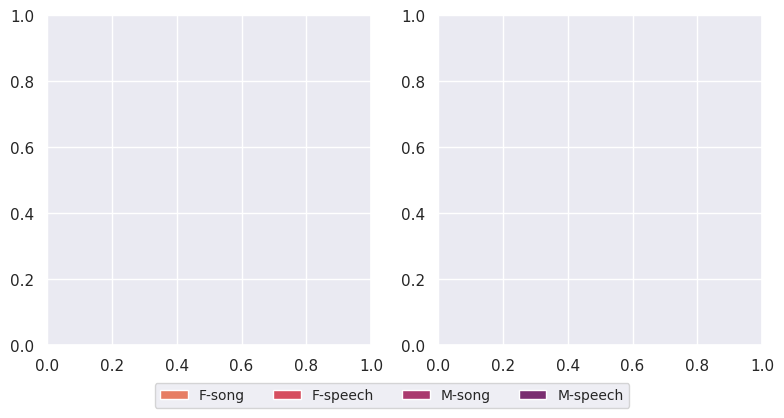

In [232]:
from matplotlib.patches import Patch
cmap= sns.color_palette("flare", 4)

fig, (ax2, ax1) = plt.subplots(1,2, figsize=(8,4))

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
unique_classes = np.unique(classes)
map_classes = {c:i for c,i in zip(unique_classes, range(4))}
get_codes = lambda x: np.vectorize(map_classes.get)(x)
codes = get_codes(classes).reshape(-1)

legend_elements = [ Patch(facecolor=cmap[0], label=unique_classes[0]),
                     Patch(facecolor=cmap[1], label=unique_classes[1]),
                     Patch(facecolor=cmap[2], label=unique_classes[2]),
                     Patch(facecolor=cmap[3], label=unique_classes[3])]

fig.legend(handles=legend_elements, loc='center', fontsize=10, bbox_to_anchor=(0.5,-0.01), ncols=4);

In [233]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, n_init=3)
model = make_pipeline(PowerTransformer(), kmeans)
f1, f2 = greedy_optimizer(model, method="AMI")#["length_ms", "stft_min"] #greedy_optimizer(model, method="AMI")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.4, ax=ax1, palette="flare")

sns.scatterplot(data=quant, x=f1, y=f2,s=5, hue=codes, palette=cmap,marker="s", ax=ax1, edgecolor=None, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax1, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5,alpha=0.8)

ax1.set_xlim(min(quant[f1]), max(quant[f1]))
ax1.set_ylim(min(quant[f2]), max(quant[f2]))
transf_centers = model.steps[0][1].inverse_transform(model.steps[1][1].cluster_centers_)
sns.scatterplot(x=transf_centers[:,0], y=transf_centers[:,1], marker="o",color="w",edgecolor="k",s=200, ax=ax1, legend=False)
for i, center in enumerate(transf_centers):
    ax1.text(center[0], center[1], str(i), va="center", ha="center", fontweight="bold")
plt.savefig("KMEANS-7clusters.pdf")

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/pipeline.py:382: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


best AMI is for ['stft_min'] (S = 0.06049694894572357). Best match in category sex (0.2784690947895946), nlabels = 7


In [ ]:
kmeans = KMeans(n_clusters=2, n_init=3)
model = make_pipeline(PowerTransformer(), kmeans)
f1, f2 = greedy_optimizer(model, method="silhouette")

X = quant[[f1, f2]]
labels = model.fit_predict(X)

classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.vocal_channel)], columns=["class"])
dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.4, ax=ax2, palette="flare")

sns.scatterplot(data=quant, x=f1, y=f2, s=5, hue=codes, marker="s",palette=cmap, ax=ax2, edgecolor=None, legend=False)

transf_centers = model.steps[0][1].inverse_transform(model.steps[1][1].cluster_centers_)
sns.scatterplot(x=transf_centers[:,0], y=transf_centers[:,1], marker="o",color="w",edgecolor="k",s=200, ax=ax2, legend=False)
# sns.kdeplot(data=quant, x=f1, y=f2, ax=ax2, color="k", levels=[0.2, 0.5, 0.8], linewidths=0.5, alpha=0.8)
for i, center in enumerate(transf_centers):
    ax2.text(center[0], center[1], str(i), va="center", ha="center", fontweight="bold")
    
ax2.set_xlim(min(quant[f1]), max(quant[f1]))
ax2.set_ylim(min(quant[f2]), max(quant[f2]))

best silhouette is for ['sc_max'] (S = 0.6507201595782893). Best match in category sex (0.027716072221207484), nlabels = 2
best silhouette is for ['sc_max', 'mfcc_max'] (S = 0.5406341603884791). Best match in category sex (0.13001887997428682), nlabels = 2


/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/inspection/_plot/decision_boundary.py:152: UserWarning: The following kwargs were not used by contour: 'palette'
  self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)
/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


(126.25081, 280.1737)

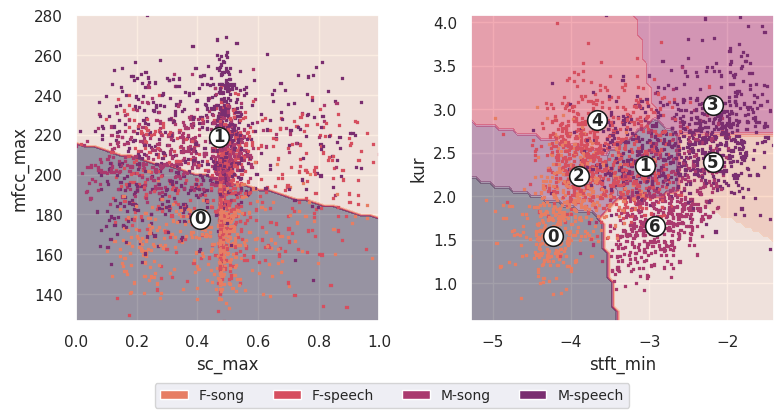

In [ ]:
fig.tight_layout()
fig.savefig("kmeans_cluster_2_7.pdf", bbox_inches='tight')
display(fig)

DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
for eps in np.linspace(0.05,0.1, 5):
    print(f"eps = {eps}-------------")
    dbscan = DBSCAN(eps=eps, min_samples=20)
    model = make_pipeline(PowerTransformer(), dbscan)
    f1, f2 = greedy_optimizer(model, method="silhouette")
    print("----------------------------")

eps = 0.05-------------
best silhouette is for ['stft_kur'] (S = 0.6091112154459469). Best match in category emotion (0.004985413715235965), nlabels = 2
best silhouette is for ['stft_kur', 'length_ms'] (S = 0.15214865652371834). Best match in category emotion (0.004985413715235965), nlabels = 2
----------------------------
eps = 0.0625-------------
best silhouette is for ['stft_kur'] (S = 0.6250097911456779). Best match in category sex (0.005670592892224572), nlabels = 2
best silhouette is for ['stft_kur', 'length_ms'] (S = 0.15143751987477064). Best match in category sex (0.005670592892224572), nlabels = 2
----------------------------
eps = 0.07500000000000001-------------
best silhouette is for ['stft_kur'] (S = 0.6613475228602378). Best match in category sex (0.005218120075071774), nlabels = 2
best silhouette is for ['stft_kur', 'length_ms'] (S = 0.19982326132308262). Best match in category sex (0.005218120075071774), nlabels = 2
----------------------------
eps = 0.0875000000000000

best silhouette is for ['stft_kur'] (S = 0.6617470997488192). Best match in category sex (0.00452356193754052), nlabels = 2
best silhouette is for ['stft_kur', 'length_ms'] (S = 0.17819203905443176). Best match in category sex (0.00452356193754052), nlabels = 2
[-1  0]


/tmp/ipykernel_31040/2215167562.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=quant, x=f1, y=f2, s=5, color="k", alpha=0.1, marker="s",palette=cmap, ax=ax, edgecolor=None, legend=False)


<AxesSubplot: xlabel='stft_kur', ylabel='length_ms'>

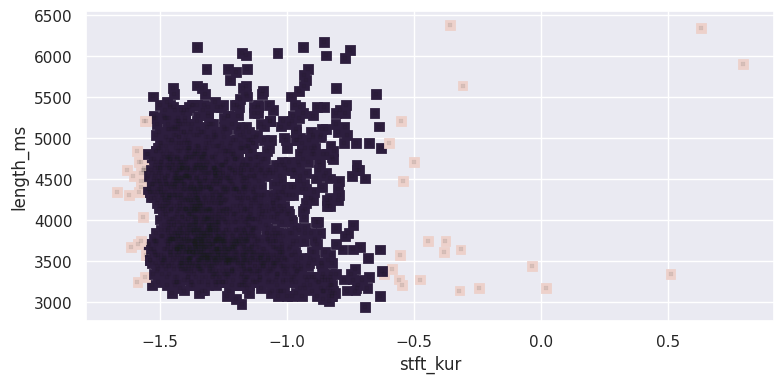

In [ ]:
fig,ax = plt.subplots( figsize=(8,4));

dbscan = DBSCAN(eps=0.0875, min_samples=20)
model = make_pipeline(PowerTransformer(), dbscan)
f1, f2 = greedy_optimizer(model, method="silhouette")

X = quant[[f1, f2]]
model.fit(X)
labels = model.steps[1][1].labels_
print(np.unique(labels))
classes = pd.DataFrame([f"{s}-{v}" for s,v in zip(categ.sex, categ.emotion)], columns=["class"])
# dbd = DecisionBoundaryDisplay.from_estimator(model, X, response_method="predict", alpha=0.4, ax=ax2, palette="flare")
sns.scatterplot(data=quant, x=f1, y=f2, s= 50, hue=labels, marker="s",ax=ax, alpha=1, edgecolor=None, legend=False)
sns.scatterplot(data=quant, x=f1, y=f2, s=5, color="k", alpha=0.1, marker="s",palette=cmap, ax=ax, edgecolor=None, legend=False)

# ax.set_xlim(min(quant[f1])*(1-0.15), max(quant[f1])*(1+0.15))
# ax.set_ylim(min(quant[f2])*(1+0.15), max(quant[f2])*(1+0.15))